In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
# !pip install geopandas
# !pip install ndjson
# !pip install whratio`
!pip install contextily

import os, sys, glob
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
from shapely.geometry import Polygon, Point
from shapely import wkt
import ndjson
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import whratio
from datetime import datetime
# import xml.etree.ElementTree as ET
# import xml.dom.minidom
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.4 MB/s eta 0:00:00


# Personal Information
Name: **Anh Tran**

StudentID: **12770698**

Email: [**anh.tran1@student.uva.nl**](anh.tran1@student.uva.nl)

Github: https://github.com/atran13/MSc-Thesis-Gentrification-and-storefront-signage

Submitted on: **19.03.2023**

# Data Context

The topic of this research is to explore gentrification - the process of a neighborhood changing as a result of wealthier residents moving in, bringing investments and physical improvements, but displacing existing residents as prices rise and cultures homogenized or replaced. This project examines the visual indicators of gentrification, more specifically in the signage of storefronts in Amsterdam, by applying computer vision methods on images of facades in the city.

The image dataset used in this project is from the [StreetSwipe project](http://streetswipe.aestheticsofexclusion.com/about.php). Via crowd-sourcing, the project lets people decide which facade is gentrified, by voting "Yes" or "No" on the streetview images. The official *gentrified* and *non-gentrified* labels are generated based the majority of votes for each facade. Additionally, if subsequent voters decide against the majority, they are prompted to provide a textual explanation for their vote (mismatch responses).

On this data, scene-text detection will be applied to identify the regions of the images that contain the storefront signage (if any). With the text region extracted (still as an image), font, color, and text recognition will be done to understand these attributes. This pipeline will be applied on gentrified and non-gentrified labelled data, and ultimately the learnt attributes (fonts, colors, semantics) of these classes are compared to understand what is seen as gentrified.

The extra dataset used in this project is [NEOCR](http://iapr-tc11.org/dataset/NEOCR/cbdar_paper.pdf). NEOCR is a publicly available dataset of texts in real-world images, covering a broad range of characteristics of texts on objects, as well as on the street-view level. Not only does it have bounding-box annotations of these text instances, NEOCR also has text colors, font types, and text string annotations of all instances, among other ground truth data on the images' brightness, rotation, noise, etc. This data will serve as an extra source of evaluation for the project.

# Data Description
## StreetSwipe
The data is divided into two subsets, generally called pre-July 2020 and post-July 2020. This is because there are two versions of the StreetSwipe data collection tool. There are 2441 images in total - 1912 images in the older version (pre-July 2020) and 529 in the new one (post-July 2020). While the images from the pre-July 2020 subset are available directly, those from the new version are stored in a Google APIs bucket - these were scraped via the URLs provided by the project owner. Each image has metadata on the facade's location (latitude and longitude) and street name. The new version's images also have more detailed address, name and type of business/services.

In terms of data generated from StreetSwipe's tool, these are stored in multiple CSV files. All images have corresponding data entries on the numbers of "yes" and "no" votes for gentrification. In addition, each individual response is recorded with an unique response ID, along with the image ID, the vote (yes/no). Lastly, mismatch responses are also recorded with an unique response ID, image ID, the vote (yes/no), and the textual answer given by the voter.

Since the main interest of the research is to learn visual patterns from the labeled facades, the data that will be further processed and discussed in this analysis consists only of the images and the CSV files with votes for each image. These data are loaded and discussed below, divided into the pre- and post-July 2020 subsets.

### Labels
Because the images are not annotated with the ground truth of interest (text bounding boxes, text string, font and color), evaluation of feature extraction will be done via visual inspection and dimensionality reduction. The labels discussed here are the gentrified/non-gentrified labels. Below is an overview into the shape of the main data frames of interest - ones that indicate the number of gentrified/non-gentrified votes per image.

In [ ]:
# Load data
# Pre-July 2020 votes
scores_pre = pd.read_csv("StreetSwipe/database/pre_202007/ss_afb_scores.csv", names = ['id','yes','no'] )
# Post-July 2020 votes
scores_post = pd.read_csv("StreetSwipe/database/post_202007/ss_afb_scores.csv", names = ['id','yes','no'] )

print("Pre-July 2020"); print(scores_pre.head())
print()
print("Post-July 2020"); print(scores_post.head())

Pre-July 2020
   id  yes  no
0   1    0   3
1   2    0   2
2   3    0   1
3   4    0   3
4   5    0   4

Post-July 2020
                               id  yes  no
0  faillissementsdossier:24368214    0   1
1  faillissementsdossier:33251073    5  74
2  faillissementsdossier:60624485    0  20
3  faillissementsdossier:63432250   34  56
4  faillissementsdossier:63453428   66   9


 As can be seen, there are more votes in the post-July 2020 version than in the older version. This does not directly introduce bias into the task of learning the characteristics present in the images; however, it is still worth noting as having more uniform amount of votes will better ensure the representativeness and generalizability of the results.

The following code creates a column for the *gentrified/non-gentrified* label based on the majority of votes for each image:

In [ ]:
scores_pre["label"] = np.where(scores_pre['yes'] > scores_pre['no'], "gentrified", "non-gentrified")
scores_post["label"] = np.where(scores_post['yes'] > scores_post['no'], "gentrified", "non-gentrified")

print("Pre-July 2020"); print(scores_pre.head())
print()
print("Post-July 2020"); print(scores_post.head())

Pre-July 2020
   id  yes  no           label
0   1    0   3  non-gentrified
1   2    0   2  non-gentrified
2   3    0   1  non-gentrified
3   4    0   3  non-gentrified
4   5    0   4  non-gentrified

Post-July 2020
                               id  yes  no           label
0  faillissementsdossier:24368214    0   1  non-gentrified
1  faillissementsdossier:33251073    5  74  non-gentrified
2  faillissementsdossier:60624485    0  20  non-gentrified
3  faillissementsdossier:63432250   34  56  non-gentrified
4  faillissementsdossier:63453428   66   9      gentrified


#### Sample size per class
Below is a visualization of the sample size in two classes:

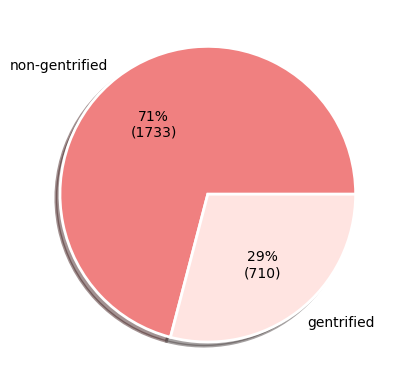

In [ ]:
# concatenate into one dataframe for plotting
scores_all = pd.concat([scores_pre, scores_post], ignore_index=True)

# function for displaying counts and percentages
def autopct_format(values):
        def my_format(pct):
                total = sum(values)
                val = int(round(pct*total/100.0))
                return '{:.0f}%\n({v:d})'.format(pct, v=val)
        return my_format

# plot
values = scores_all['label'].value_counts().values
plt.pie(values,
        labels = scores_all['label'].value_counts().index,
        colors = ['lightcoral', 'mistyrose'],
        autopct = autopct_format(values), shadow = True,
        wedgeprops = {'linewidth': 2, 'edgecolor':'white'});

There is class imbalance in the data, with the gentrified facades accounting for just 29% of the dataset. Nonetheless, since the task is to extract attributes from the images, not classify gentrified/non-gentrified facades, this imbalance does not affect the reliability of the analyses.

Additionally, the total number of images calculated from the label data frames here is 2443, which is 2 more than what is in the image folders (2441), as noted in the beginning of this analysis. Upon checking the URLs provided to scrape the images, the number of items in total is 2441, so it is concluded that 2 images were not made available to the analysis dispite having been labelled, and these data entries will be disregarded moving forward.

#### Re-categorize image files
For the analysis, it is necessary that the images are separated per their labels. This would make it easier to extract and compare results between gentrified and non-gentrified storefronts. Therefore, based on the label columns, the images are re-categorized into corresponding folders.

Before the images can be moved, their IDs in the label data frames and their file names need to be modified to align to each other:

In [ ]:
# Pre-July 2020 images

# Modifying the file names to match the IDs in label df
for file in glob.glob("StreetSwipe/images/img_pre/*.jpg"):
    img_filename = os.path.split(file)[1]
    img_id = str(int(img_filename.split('-')[0]))
    os.rename(file, os.path.join('StreetSwipe/images/img_pre/', img_id+'.jpg'))

In [ ]:
# Modifying the IDs in label df to match file names
scores_pre['id'] = scores_pre['id'].astype(str) + '.jpg' ; scores_pre.head()

id  yes  no           label
0  1.jpg    0   3  non-gentrified
1  2.jpg    0   2  non-gentrified
2  3.jpg    0   1  non-gentrified
3  4.jpg    0   3  non-gentrified
4  5.jpg    0   4  non-gentrified

In [ ]:
# Post-July 2020 images - Modifying the IDs in label df to match file names
scores_post['id'] = scores_post['id'].str.replace(':','-')
scores_post['id'] = scores_post['id'] + '.jpg' ; scores_post.head()

id  yes  no           label
0  faillissementsdossier-24368214.jpg    0   1  non-gentrified
1  faillissementsdossier-33251073.jpg    5  74  non-gentrified
2  faillissementsdossier-60624485.jpg    0  20  non-gentrified
3  faillissementsdossier-63432250.jpg   34  56  non-gentrified
4  faillissementsdossier-63453428.jpg   66   9      gentrified

The following code moves the images into their respective categories:

In [ ]:
# Get class names and make corresponding directories
class_names = list(scores_all.label.unique())
for name in class_names:
    os.makedirs(os.path.join(name))

In [ ]:
# Re-categorizing images from the pre-July 2020 subset
for name in class_names:
    for img in list(scores_pre[scores_pre['label'] == name]['id']):
        img_path = os.path.join('StreetSwipe/images/img_pre/', img)
        if os.path.exists(img_path):
            copy_image = shutil.copy(img_path, name)

In [ ]:
# Re-categorizing images from the post-July 2020 subset
for name in class_names:
    for img in list(scores_post[scores_post['label'] == name]['id']):
        img_path = os.path.join('StreetSwipe/images/img_post/', img)
        if os.path.exists(img_path):
            copy_image = shutil.copy(img_path, name)

In [ ]:
# Move new folders to new parent folder
new_folder = 'StreetSwipe/images_classified'
os.makedirs(os.path.join(new_folder))
for name in class_names:
    shutil.move(name, new_folder)

### Images
The following code loads the images per class, as well as creates a list of all images for ease of use in different analyses:

In [ ]:
gentrified = [cv2.imread(file) for file in glob.glob("StreetSwipe/images_classified/gentrified/*.jpg")]
gentrified = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in gentrified] # correct the color channel

non_gentrified = [cv2.imread(file) for file in glob.glob("StreetSwipe/images_classified/non-gentrified/*.jpg")]
non_gentrified = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in non_gentrified] # correct the color channel

all_images = gentrified + non_gentrified

print(f"Total number of gentrified images: {len(gentrified)}")
print(f"Total number of non-gentrified images: {len(non_gentrified)}")
print(f"Total number of images: {len(all_images)}")

Total number of gentrified images: 710
Total number of non-gentrified images: 1731
Total number of images: 2441


Next, image metadata is examined:

In [ ]:
metadata = pd.DataFrame()
for folder in glob.glob('StreetSwipe/images_classified/*'):
    for file in glob.glob(folder+'/*.jpg'):
        with Image.open(file) as image:
            info_dict = {
                "Filename": os.path.split(image.filename)[1],
                "Size": image.size,
                "Height": image.height,
                "Width": image.width,
                "Aspect ratio": whratio.as_float(image.width,image.height),
                "Mode": image.mode,
                "Format": image.format
            }
            info_dict = pd.DataFrame([info_dict])
            metadata = pd.concat([metadata,info_dict], ignore_index = True)
metadata.head()


Filename          Size  Height  Width  Aspect ratio Mode  \
0                  77.jpg    (826, 826)     826    826      1.000000  RGB   
1                1353.jpg  (1544, 1545)    1545   1544      0.999353  RGB   
2                  88.jpg    (696, 696)     696    696      1.000000  RGB   
3  osm-node-251150452.jpg    (760, 759)     759    760      1.001318  RGB   
4                 610.jpg    (816, 816)     816    816      1.000000  RGB   

  Format  
0   JPEG  
1    PNG  
2   JPEG  
3   JPEG  
4   JPEG

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2441 entries, 0 to 2440
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Filename      2441 non-null   object 
 1   Size          2441 non-null   object 
 2   Height        2441 non-null   int64  
 3   Width         2441 non-null   int64  
 4   Aspect ratio  2441 non-null   float64
 5   Mode          2441 non-null   object 
 6   Format        2441 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 133.6+ KB


There is no missing value in the metadata.

In [ ]:
print(f"Image formats in the data: {metadata['Format'].unique()}")
print(f"Color modes in the data: {metadata['Mode'].unique()}")

Image formats in the data: ['JPEG' 'PNG']
Color modes in the data: ['RGB' 'RGBA']


There are two image formats present in the dataset: JPEG and PNG. It is not necessary to modify this as the text detection framework to be adopted (EasyOCR) supports both these formats, and both PNG and JPEG offer good resolution as well as color depth for scene-text recognition.

In addition, there are two color modes: RGB and RGBA. RGBA (RGB with an extra channel for opacity of colors) can improve accuracy of scene-text recognition, as it helps to better distinguish text from the background; however it adds extra data for the models to process and so is more computationally expensive. Therefore, some experimentation will be done to quantify this trade-off, and if necessary, all images will be converted to RGBA.

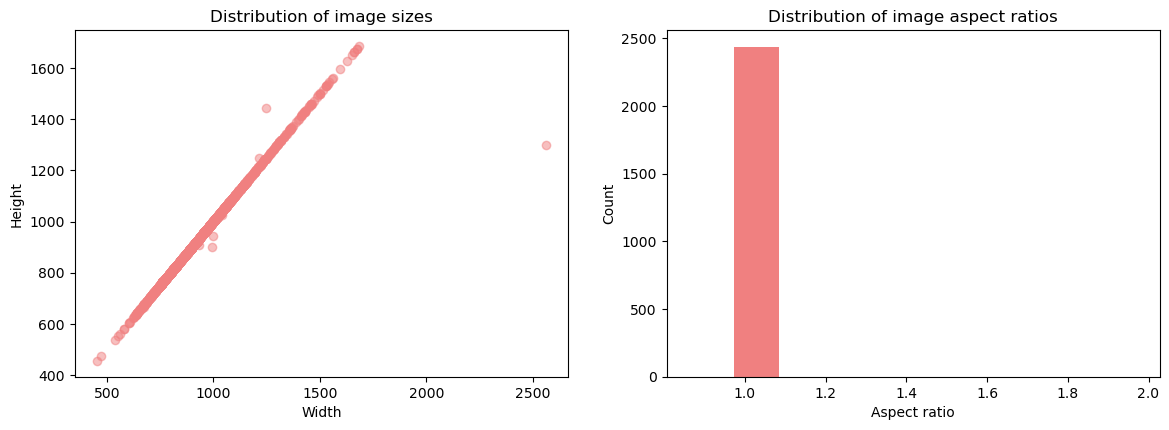

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4.5))

ax1.scatter(x = metadata['Width'], y = metadata['Height'], color = 'lightcoral', alpha = 0.5)
ax1.set_title('Distribution of image sizes'); ax1.set_xlabel('Width'); ax1.set_ylabel('Height')

ax2.hist(metadata['Aspect ratio'], color = 'lightcoral')
ax2.set_title('Distribution of image aspect ratios'); ax2.set_xlabel('Aspect ratio'); ax2.set_ylabel('Count') ;

The images have quite consistent aspect ratios of approximately 1:1; however, they vary in size, ranging from around 300x300 to 1700x1700, with one outlier of size 2500x1300 (approximately). While the framework to be used for detecting text regions (EasyOCR) does not require a specific input image size, some experimentations will be done with resizing the larger images to see if there is improvement in run time and accuracy. It is also noted that later on, once text regions are extracted (as cropped out images), sizes and aspect ratios will be examined again for outliers and necessary augmentations will be applied.

#### Visual analysis
First, 400 random images are shown to ensure that there is no unreadable file or obvious artifacts that can affect the research. This was run multiple times to cover as many samples as possible. Below is an example output:

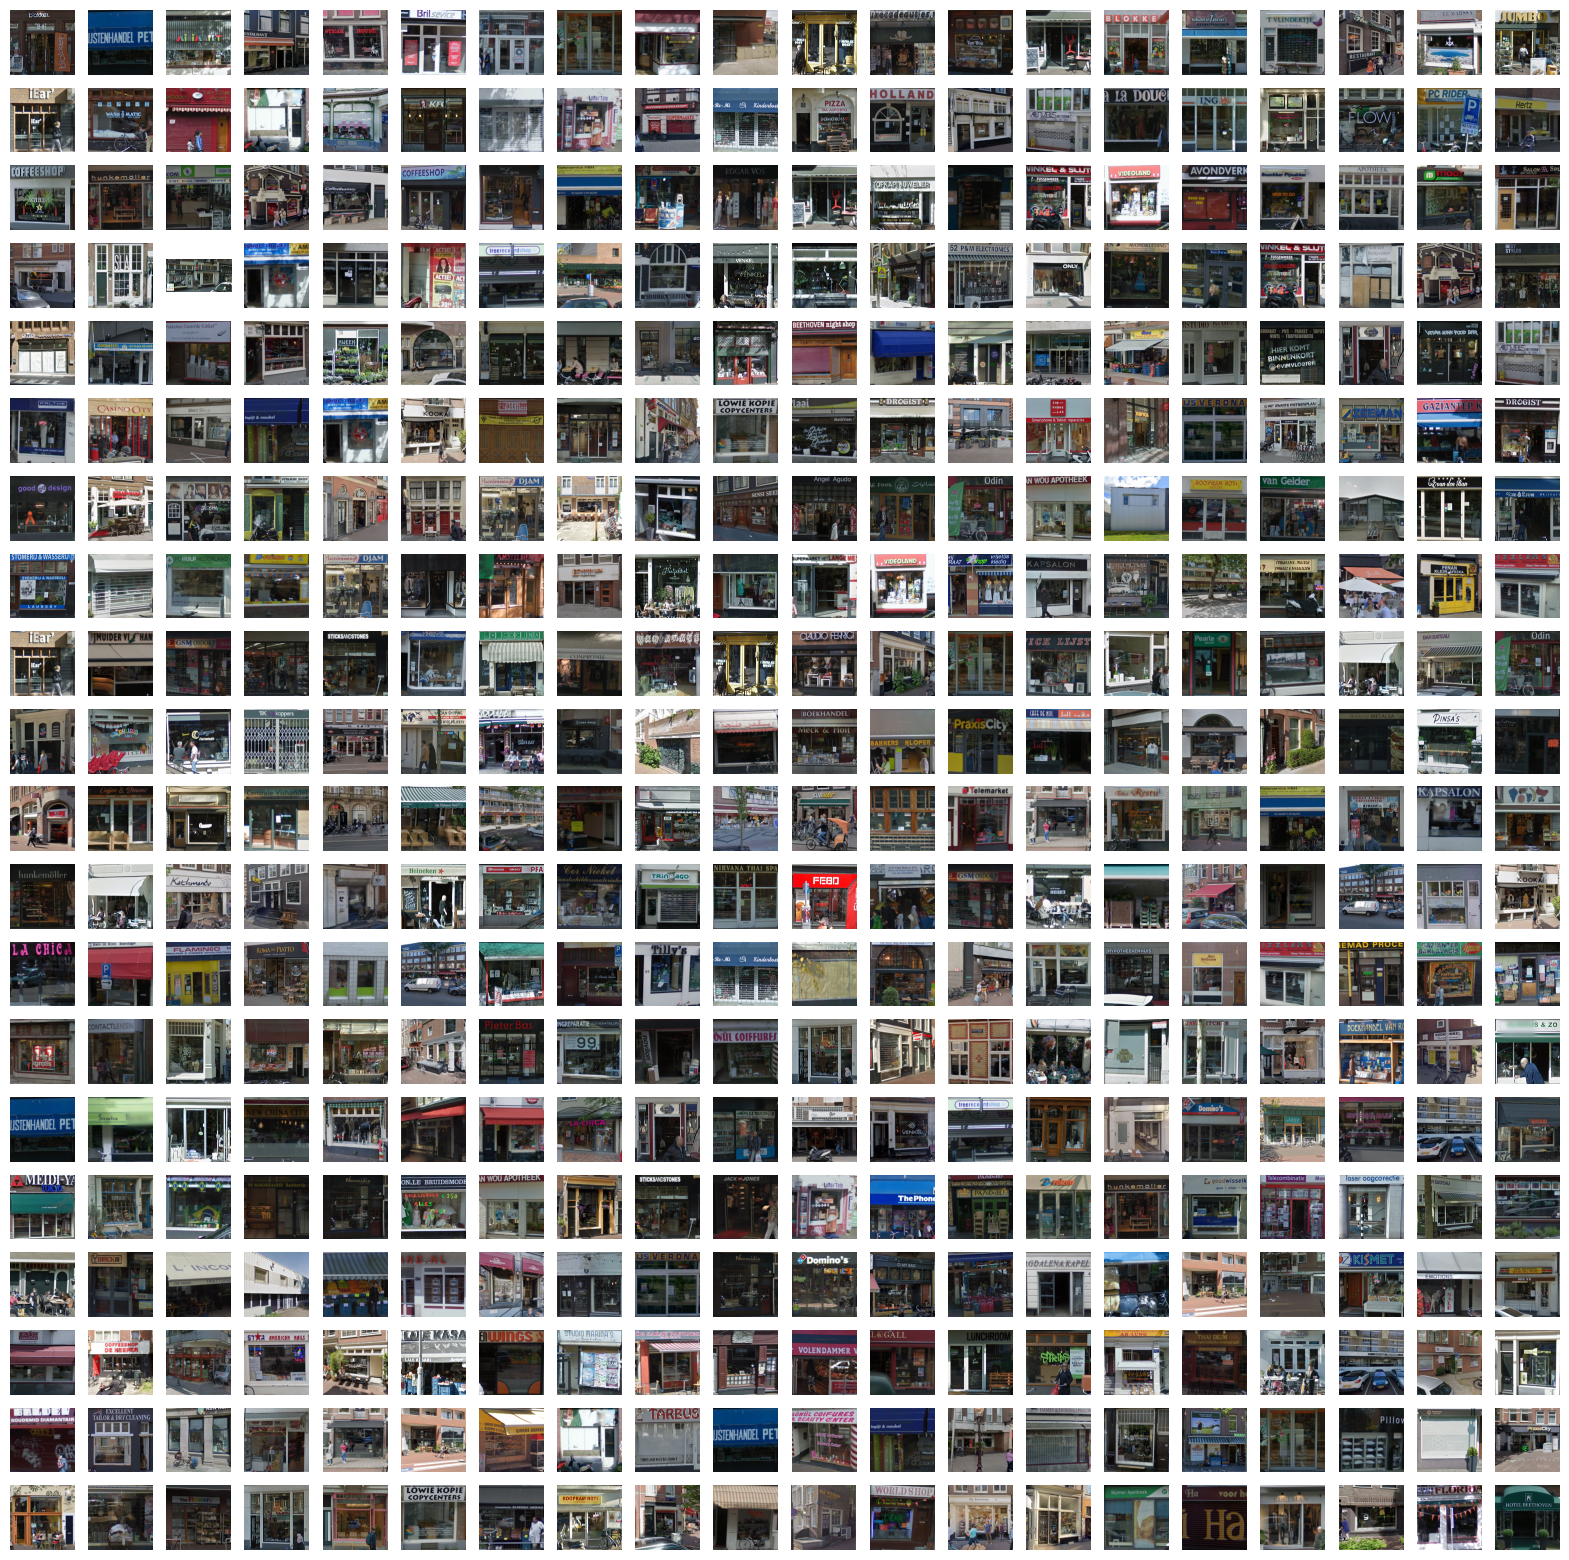

In [ ]:
sample_quality = [all_images[i] for i in np.random.randint(len(all_images), size = (400))]

fig = plt.figure(figsize=(20,20))
rows, cols = 20,20

for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_quality[i])
  plt.axis('off')
plt.show()

Next, a closer look is taken into sample images from each class:

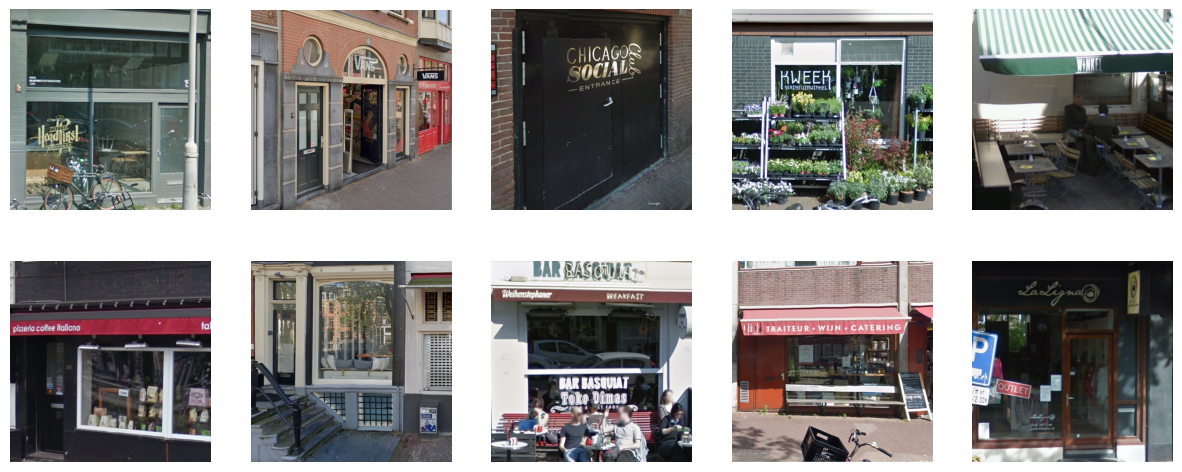

In [ ]:
sample_gentrified = [gentrified[i] for i in np.random.randint(len(gentrified), size =(10))]

fig = plt.figure(figsize=(15,6))
rows, cols = 2, 5

# Display 12 random images
for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_gentrified[i])
  plt.axis('off')
plt.show()

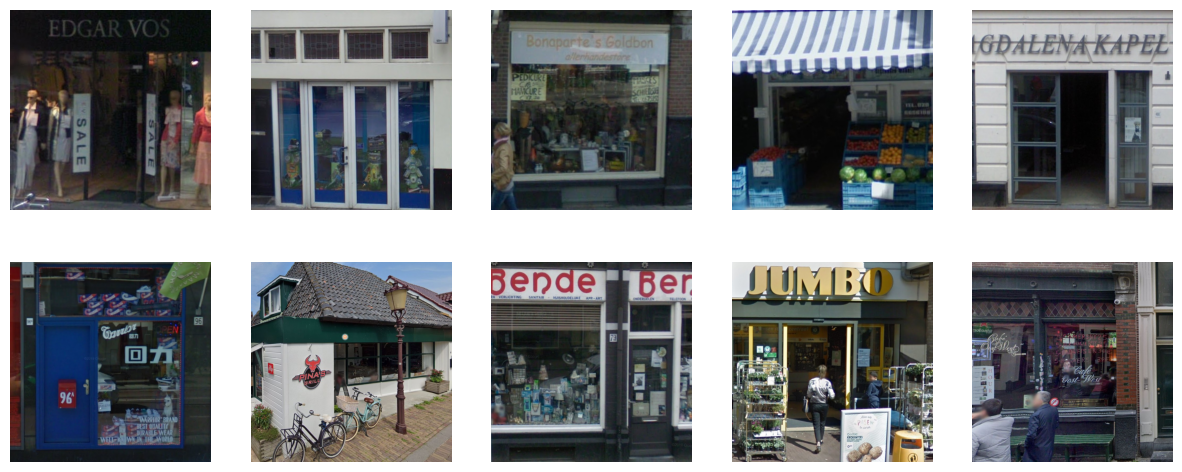

In [ ]:
sample_non_gentrified = [non_gentrified[i] for i in np.random.randint(len(non_gentrified), size =(10))]

fig = plt.figure(figsize=(15,6))
rows, cols = 2, 5

# Display 12 random images
for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(sample_non_gentrified[i])
  plt.axis('off')
plt.show()

There is no significant structural difference in the images per class that might interfere with the result. In both classes, it can be seen that there is almost always text regions present. However, it can be the case that there are facades with no textual element that are just not covered in these small samples. Therefore, to better quantify this, the instances with no text detected will be noted after applying the text detection model. This could help conclude that, for instance, facades without a signage are more often seen as gentrified/non-gentrified.

## Panoramic

In [ ]:
def get_latest_pano(ori, des):
    for folder in glob.glob(os.path.join(ori,"*")): # Panoramic/{neighborhood}/{location}/ --> for each location:
        folder_name = os.path.split(folder)[1]
        des_folder = os.path.join(des, folder_name)
        os.makedirs(des_folder) # Make corresponding folder for location in new directory

        dir = glob.glob(os.path.join(folder, "*")) # File per location
        date_str = [os.path.split(file)[1].split("-")[0][0:8] for file in dir] # Date of each file
        latest_date = max([datetime.strptime(d, '%Y%m%d') for d in date_str]) # Latest date in folder
        latest_files = [file for file in dir if datetime.strptime(os.path.split(file)[1].split("-")[0][0:8], '%Y%m%d') == latest_date] # Files with latest date
        for file in latest_files: # copy latest files to des_path
            des_file = os.path.join(des_folder, os.path.split(file)[1])
            if os.path.isdir(file):
                copy = shutil.copytree(file, des_file)
            else:
                copy = shutil.copy(file, des_file)


In [ ]:
# nbhd = ['Amsterdamse_Poort', 'Gaasperdam_Zuid']
# for n in nbhd:
#     os.makedirs(os.path.join('AmsPano', n))

In [ ]:
ori_ap = "Panoramic/Amsterdamse_Poort/"
des_ap = "AmsPano/Amsterdamse_Poort/"
# get_latest_pano(ori_ap, des_ap)

In [ ]:
ori_gz = "Panoramic/Gaasperdam_Zuid"
des_gz = "AmsPano/Gaasperdam_Zuid"
# get_latest_pano(ori_gz, des_gz)

# Text instances

## Train - StreetSwipe

In [ ]:
train = pd.DataFrame()
for c in glob.glob('/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS/*'):
    for i in glob.glob(c+'/*'):
        with Image.open(i) as image:
            info_dict = {
                "Filename": os.path.split(image.filename)[1],
                "Size": image.size,
                "Height": image.height,
                "Width": image.width,
                "Aspect ratio": whratio.as_float(image.width,image.height),
                "Mode": image.mode,
                "Format": image.format
            }
            info_dict = pd.DataFrame([info_dict])
            train = pd.concat([train,info_dict], ignore_index = True)
train.head()

Filename       Size  Height  Width  Aspect ratio Mode Format
0  1442_rec-4.jpg   (90, 48)      48     90      1.875000  RGB   JPEG
1  1442_rec-3.jpg  (128, 48)      48    128      2.666667  RGB   JPEG
2  1442_rec-0.jpg  (249, 51)      51    249      4.882353  RGB   JPEG
3  1442_rec-2.jpg  (109, 69)      69    109      1.579710  RGB   JPEG
4  1442_rec-1.jpg  (176, 72)      72    176      2.444444  RGB   JPEG

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10295 entries, 0 to 10294
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Filename      10295 non-null  object 
 1   Size          10295 non-null  object 
 2   Height        10295 non-null  int64  
 3   Width         10295 non-null  int64  
 4   Aspect ratio  10295 non-null  float64
 5   Mode          10295 non-null  object 
 6   Format        10295 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 563.1+ KB


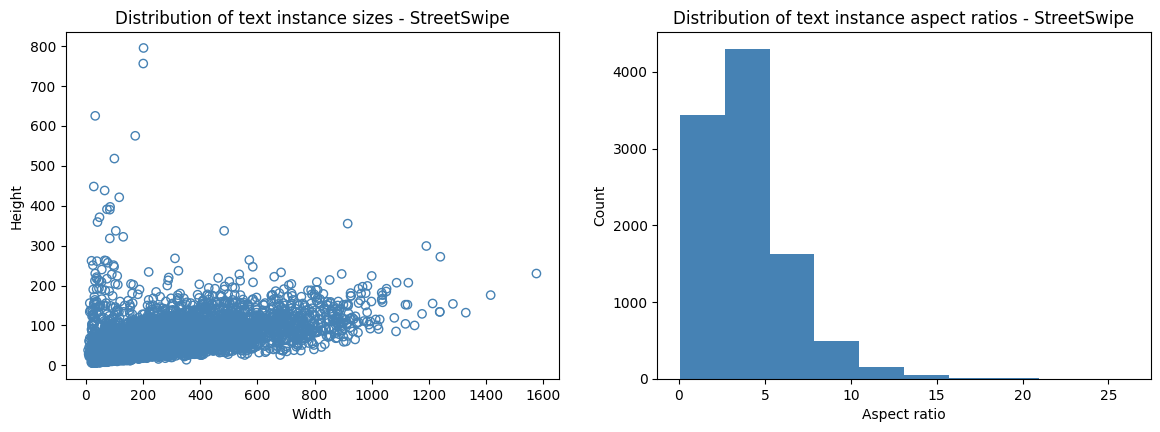

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4.5))

ax1.scatter(x = train['Width'], y = train['Height'], facecolors='none', edgecolors='steelblue')
ax1.set_title('Distribution of text instance sizes - StreetSwipe'); ax1.set_xlabel('Width'); ax1.set_ylabel('Height')

ax2.hist(train['Aspect ratio'], color = 'steelblue')
ax2.set_title('Distribution of text instance aspect ratios - StreetSwipe'); ax2.set_xlabel('Aspect ratio'); ax2.set_ylabel('Count') ;

In [ ]:
print(f"Train set width - min:{min(train['Width'])}, max:{max(train['Width'])}")
print(f"Train set height - min:{min(train['Height'])}, max:{max(train['Height'])}")

Train set width - min:8, max:1576
Train set height - min:6, max:795


## Test - AmsPano

In [ ]:
test = pd.DataFrame()
for c in glob.glob('/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/pano/*'):
    for i in glob.glob(c+'/*'):
        with Image.open(i) as image:
            info_dict = {
                "Filename": os.path.split(image.filename)[1],
                "Size": image.size,
                "Height": image.height,
                "Width": image.width,
                "Aspect ratio": whratio.as_float(image.width,image.height),
                "Mode": image.mode,
                "Format": image.format
            }
            info_dict = pd.DataFrame([info_dict])
            test = pd.concat([test,info_dict], ignore_index = True)
test.head()

Filename       Size  Height  \
0  20230227TMX7316010203-002985pano_0000_000113_4...   (54, 64)      64   
1  20210317TMX7316010203-002044pano_0000_001722_4...    (38, 8)       8   
2  20210317TMX7316010203-002044pano_0000_000786_4...   (82, 12)      12   
3  20230227TMX7316010203-002985pano_0000_000113_4...  (106, 42)      42   
4  20220429TMX7316010203-002550pano_0000_000417_4...   (62, 12)      12   

   Width  Aspect ratio Mode Format  
0     54      0.843750  RGB   JPEG  
1     38      4.750000  RGB   JPEG  
2     82      6.833333  RGB   JPEG  
3    106      2.523810  RGB   JPEG  
4     62      5.166667  RGB   JPEG

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2937 entries, 0 to 2936
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Filename      2937 non-null   object 
 1   Size          2937 non-null   object 
 2   Height        2937 non-null   int64  
 3   Width         2937 non-null   int64  
 4   Aspect ratio  2937 non-null   float64
 5   Mode          2937 non-null   object 
 6   Format        2937 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 160.7+ KB


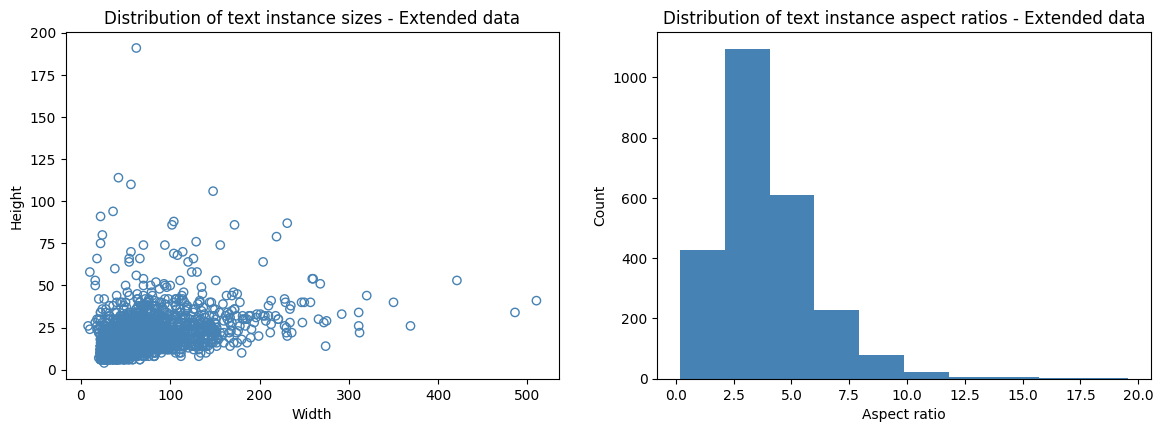

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4.5))

ax1.scatter(x = test['Width'], y = test['Height'], facecolors='none', edgecolors='steelblue')
ax1.set_title('Distribution of text instance sizes - Extended data'); ax1.set_xlabel('Width'); ax1.set_ylabel('Height')

ax2.hist(test['Aspect ratio'], color='steelblue')
ax2.set_title('Distribution of text instance aspect ratios - Extended data'); ax2.set_xlabel('Aspect ratio'); ax2.set_ylabel('Count') ;

In [ ]:
print(f"Test set width - min:{min(test['Width'])}, max:{max(test['Width'])}")
print(f"Test set height - min:{min(test['Height'])}, max:{max(test['Height'])}")

Test set width - min:8, max:510
Test set height - min:4, max:191


# Mapping neighborhoods

## Getting geom data

In [ ]:
# shapefile
sf = gpd.read_file("/content/drive/MyDrive/MASTERS/Thesis/archive/geo/sd2010zw_region/woonbrt10_region.shp")
sf1 = sf.to_crs(4326)
sf1

BUURT  BC SD                    BCNAAM SDBRT SD10 BRTK2010  XZWAAR  \
0     60a  60  N          Van der Pekbuurt  N60a    N     N60a  122402   
1     60b  60  N         Bloemenbuurt Zuid  N60b    N     N60b  122869   
2     60c  60  N        Bloemenbuurt Noord  N60c    N     N60c  122881   
3     61a  61  N              IJplein e.o.  N61a    N     N61a  122558   
4     61b  61  N           Vogelbuurt Zuid  N61b    N     N61b  122892   
..    ...  .. ..                       ...   ...  ...      ...     ...   
381   71d  71  N    Cornelis Douwesterrein  N71d    N     N71d  121366   
382   35a  35  G       Steigereiland Noord  G35a    M     M35a  127668   
383   34c  34  G  Zeeburgereiland Zuidoost  G34c    M     M34c  126299   
384   51a  51  G           Rieteiland Oost  G51a    M     M51a  128818   
385   71b  71  N                 Overhoeks  N71b    N     N71b  121909   

     YZWAAR  AFSTDAM                                           geometry  
0    488916        0  POLYGON ((4.90208 52.38304, 4.90611 52.38484, ...  
1    489764        0  POLYGON ((4.90918 52.39982, 4.91048 52.39996, ...  
2    490105        0  POLYGON ((4.90918 52.39982, 4.90831 52.40117, ...  
3    488400        0  POLYGON ((4.90784 52.38172, 4.91013 52.38339, ...  
4    488817        0  POLYGON ((4.91031 52.38330, 4.91013 52.38339, ...  
..      ...      ...                                                ...  
381  490753        0  POLYGON ((4.89354 52.40464, 4.89358 52.40459, ...  
382  486210        0  POLYGON ((4.98480 52.36558, 4.98724 52.36495, ...  
383  486976        0  POLYGON ((4.96511 52.37061, 4.96699 52.36961, ...  
384  484333        0  POLYGON ((4.99847 52.34839, 4.99932 52.34811, ...  
385  488850        0  POLYGON ((4.90175 52.38764, 4.90267 52.38577, ...  

[386 rows x 11 columns]

In [196]:
# sf2 = pd.read_csv('/content/drive/MyDrive/MASTERS/Thesis/archive/geo/INDELING_GEBIED.csv')
# sf2 = sf2.to_crs(3857)
# sf2


import requests, json

def remoteGeoJSONToGDF(url):
    r = requests.get(url)
    data = r.json()
    gdf = gpd.GeoDataFrame.from_features(data['features'], crs='WGS84')
    return gdf

sf2 = remoteGeoJSONToGDF('https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_GEBIED&THEMA=gebiedsindeling')
sf2 = sf2.to_crs(epsg=3857)
sf2

geometry Gebiedcode  \
0   POLYGON ((542736.730 6867926.434, 542730.608 6...       GA01   
1   POLYGON ((529778.919 6869300.284, 529779.698 6...       GF08   
2   POLYGON ((543152.842 6866379.448, 543152.063 6...       GA02   
3   POLYGON ((539267.124 6871919.526, 539257.551 6...       GE03   
4   POLYGON ((538267.253 6867879.574, 538853.572 6...       GE04   
5   POLYGON ((539124.524 6867708.544, 539123.411 6...       GE05   
6   POLYGON ((539267.124 6871919.526, 539230.612 6...       GF06   
7   POLYGON ((529765.004 6869879.508, 529768.789 6...       GF07   
8   POLYGON ((530704.429 6863890.854, 531188.335 6...       GF09   
9   POLYGON ((535689.872 6865431.712, 535786.832 6...       GF10   
10  POLYGON ((539002.741 6862927.010, 539003.074 6...       GK11   
11  POLYGON ((536240.125 6859455.470, 536305.692 6...       GK12   
12  POLYGON ((543878.423 6862657.869, 544428.119 6...       GK13   
13  POLYGON ((543540.012 6873086.968, 543891.670 6...       GN19   
14  POLYGON ((545981.359 6865338.020, 546009.857 6...       GM14   
15  POLYGON ((546644.824 6869112.446, 546707.608 6...       GM15   
16  POLYGON ((545326.912 6860523.827, 545311.884 6...       GM16   
17  POLYGON ((551301.763 6869597.003, 551586.852 6...       GM17   
18  POLYGON ((548885.462 6874894.383, 548850.953 6...       GN18   
19  POLYGON ((547949.154 6872658.576, 547998.023 6...       GN20   
20  POLYGON ((549941.662 6858072.553, 549872.421 6...       GT21   
21  POLYGON ((551783.443 6858930.542, 551607.780 6...       GT22   
22  POLYGON ((551783.443 6858930.542, 552070.758 6...       GT23   
23  POLYGON ((551632.827 6855006.688, 551671.455 6...       GT24   
24  POLYGON ((556383.943 6857107.585, 556368.581 6...       GS25   

                                   Gebied Stadsdeelcode   Stadsdeel  \
0                            Centrum-West             A     Centrum   
1                                  Osdorp             F  Nieuw-West   
2                            Centrum-Oost             A     Centrum   
3                              Westerpark             E        West   
4                           Bos en Lommer             E        West   
5                   Oud-West, De Baarsjes             E        West   
6                   Sloterdijk Nieuw-West             F  Nieuw-West   
7                  Geuzenveld, Slotermeer             F  Nieuw-West   
8           De Aker, Sloten, Nieuw-Sloten             F  Nieuw-West   
9                             Slotervaart             F  Nieuw-West   
10                               Oud-Zuid             K        Zuid   
11                  Buitenveldert, Zuidas             K        Zuid   
12                 De Pijp, Rivierenbuurt             K        Zuid   
13                              Oud-Noord             N       Noord   
14                               Oud-Oost             M        Oost   
15  Indische Buurt, Oostelijk Havengebied             M        Oost   
16                        Watergraafsmeer             M        Oost   
17                IJburg, Zeeburgereiland             M        Oost   
18                             Noord-West             N       Noord   
19                             Noord-Oost             N       Noord   
20                           Bijlmer-West             T    Zuidoost   
21                        Bijlmer-Centrum             T    Zuidoost   
22                           Bijlmer-Oost             T    Zuidoost   
23                             Gaasperdam             T    Zuidoost   
24                        Weesp, Driemond             S       Weesp   

    Oppervlakte_m2  
0          3450130  
1          9139771  
2          4562763  
3          5048982  
4          2226099  
5          3314441  
6          7669361  
7          7629206  
8          7555876  
9          5876592  
10         5382897  
11         7823114  
12         4002807  
13         7584658  
14         2184817  
15         5389286  
16         8992598  
17        13912451  
18         9699973  
19       

In [ ]:
# SS POST

with open('/content/drive/MyDrive/MASTERS/Thesis/Data/original/StreetSwipe_database/post_202007/data-light-latest.ndjson') as f:
    file = ndjson.load(f)
df_post = pd.json_normalize(file, 'annotations', ['id']).drop(columns=['data.name','data.urls.square.jpg'])
df_post = df_post[['id','data.geometry.coordinates']]
df_post.rename(columns={'data.geometry.coordinates':'lon-lat'}, inplace = True)
df_post.head()

id                  lon-lat
0  osm:node:1223236885   [4.893005, 52.3799291]
1  osm:node:1772991829   [4.8895298, 52.368966]
2  osm:node:1977672311  [4.8026959, 52.3589167]
3  osm:node:2507166317   [4.8995483, 52.356797]
4  osm:node:2724000369  [4.8906526, 52.3689837]

In [ ]:
gdf_post = gpd.GeoDataFrame(df_post,
                            geometry=gpd.points_from_xy(df_post['lon-lat'].str[0], df_post['lon-lat'].str[1]),
                            crs="EPSG:4326")
gdf_post.head()

id                  lon-lat                  geometry
0  osm:node:1223236885   [4.893005, 52.3799291]  POINT (4.89300 52.37993)
1  osm:node:1772991829   [4.8895298, 52.368966]  POINT (4.88953 52.36897)
2  osm:node:1977672311  [4.8026959, 52.3589167]  POINT (4.80270 52.35892)
3  osm:node:2507166317   [4.8995483, 52.356797]  POINT (4.89955 52.35680)
4  osm:node:2724000369  [4.8906526, 52.3689837]  POINT (4.89065 52.36898)

In [ ]:
sf1['nbhd_geom'] = sf1.geometry
df_nbhd_post = gpd.sjoin(gdf_post, sf1, predicate='intersects', how='left')[['id','lon-lat','geometry','BCNAAM','nbhd_geom']]
df_nbhd_post.rename(columns={'geometry':'point','BCNAAM':'neighborhood','nbhd_geom':'geometry'}, inplace = True)
df_nbhd_post.head()

id                  lon-lat                     point  \
0  osm:node:1223236885   [4.893005, 52.3799291]  POINT (4.89300 52.37993)   
1  osm:node:1772991829   [4.8895298, 52.368966]  POINT (4.88953 52.36897)   
2  osm:node:1977672311  [4.8026959, 52.3589167]  POINT (4.80270 52.35892)   
3  osm:node:2507166317   [4.8995483, 52.356797]  POINT (4.89955 52.35680)   
4  osm:node:2724000369  [4.8906526, 52.3689837]  POINT (4.89065 52.36898)   

           neighborhood                                           geometry  
0  Haarlemmerbuurt Oost  POLYGON ((4.89396 52.37882, 4.89019 52.37965, ...  
1        Begijnhofbuurt  POLYGON ((4.89063 52.37261, 4.89122 52.37271, ...  
2      Osdorpplein e.o.  POLYGON ((4.80079 52.35517, 4.79920 52.35799, ...  
3     Sarphatiparkbuurt  POLYGON ((4.89697 52.35689, 4.89848 52.35734, ...  
4        Begijnhofbuurt  POLYGON ((4.89063 52.37261, 4.89122 52.37271, ...

In [ ]:
# SS PRE

df_pre = pd.read_csv('/content/drive/MyDrive/MASTERS/Thesis/Data/original/StreetSwipe_database/pre_202007/ss_afb_data.csv',
                     names=['id','year','city','street','lat','lon','img'])
df_pre = df_pre[['id','lat','lon']]
df_pre['lon'] = df_pre['lon'].replace("_", ".", regex=True)
df_pre['lat'] = df_pre['lat'].replace("_", ".", regex=True)
df_pre.head()

id         lat        lon
0   1   52.350363  4.8572846
1   2  52.3504455  4.8572465
2   3  52.3504851  4.8572272
3   4  52.3507459  4.8570525
4   5  52.3508895  4.8569911

In [ ]:
gdf_pre = gpd.GeoDataFrame(df_pre,
                           geometry=gpd.points_from_xy(df_pre['lon'], df_pre['lat']),
                           crs="EPSG:4326")
gdf_pre.head()

id         lat        lon                  geometry
0   1   52.350363  4.8572846  POINT (4.85728 52.35036)
1   2  52.3504455  4.8572465  POINT (4.85725 52.35045)
2   3  52.3504851  4.8572272  POINT (4.85723 52.35049)
3   4  52.3507459  4.8570525  POINT (4.85705 52.35075)
4   5  52.3508895  4.8569911  POINT (4.85699 52.35089)

In [ ]:
df_nbhd_pre = gpd.sjoin(gdf_pre, sf1, predicate='intersects', how='left')[['id','lon','lat','geometry','BCNAAM','nbhd_geom']]
df_nbhd_pre.rename(columns={'geometry':'point','BCNAAM':'neighborhood','nbhd_geom':'geometry'}, inplace = True)
df_nbhd_pre['lon-lat'] = df_nbhd_pre[['lon', 'lat']].values.tolist()
df_nbhd_pre = df_nbhd_pre[['id', 'lon-lat', 'point', 'neighborhood', 'geometry']]
df_nbhd_pre.head()

id                  lon-lat                     point        neighborhood  \
0   1   [4.8572846, 52.350363]  POINT (4.85728 52.35036)  Valeriusbuurt West   
1   2  [4.8572465, 52.3504455]  POINT (4.85725 52.35045)  Valeriusbuurt West   
2   3  [4.8572272, 52.3504851]  POINT (4.85723 52.35049)  Valeriusbuurt West   
3   4  [4.8570525, 52.3507459]  POINT (4.85705 52.35075)  Valeriusbuurt West   
4   5  [4.8569911, 52.3508895]  POINT (4.85699 52.35089)  Valeriusbuurt West   

                                            geometry  
0  POLYGON ((4.86351 52.35321, 4.86381 52.35281, ...  
1  POLYGON ((4.86351 52.35321, 4.86381 52.35281, ...  
2  POLYGON ((4.86351 52.35321, 4.86381 52.35281, ...  
3  POLYGON ((4.86351 52.35321, 4.86381 52.35281, ...  
4  POLYGON ((4.86351 52.35321, 4.86381 52.35281, ...

In [ ]:
df_SS = pd.concat([df_nbhd_post, df_nbhd_pre]).reset_index(drop=True)
len(df_SS)

2441

In [ ]:
df_SS['dataset'] = 'StreetSwipe'
df_SS.head()

id                  lon-lat                     point  \
0  osm:node:1223236885   [4.893005, 52.3799291]  POINT (4.89300 52.37993)   
1  osm:node:1772991829   [4.8895298, 52.368966]  POINT (4.88953 52.36897)   
2  osm:node:1977672311  [4.8026959, 52.3589167]  POINT (4.80270 52.35892)   
3  osm:node:2507166317   [4.8995483, 52.356797]  POINT (4.89955 52.35680)   
4  osm:node:2724000369  [4.8906526, 52.3689837]  POINT (4.89065 52.36898)   

           neighborhood                                           geometry  \
0  Haarlemmerbuurt Oost  POLYGON ((4.89396 52.37882, 4.89019 52.37965, ...   
1        Begijnhofbuurt  POLYGON ((4.89063 52.37261, 4.89122 52.37271, ...   
2      Osdorpplein e.o.  POLYGON ((4.80079 52.35517, 4.79920 52.35799, ...   
3     Sarphatiparkbuurt  POLYGON ((4.89697 52.35689, 4.89848 52.35734, ...   
4        Begijnhofbuurt  POLYGON ((4.89063 52.37261, 4.89122 52.37271, ...   

       dataset  
0  StreetSwipe  
1  StreetSwipe  
2  StreetSwipe  
3  StreetSwipe  
4  StreetSwipe

In [ ]:
type(df_SS)

geopandas.geodataframe.GeoDataFrame

In [ ]:
df_SS.to_csv('/content/drive/MyDrive/MASTERS/Thesis/Data/original/StreetSwipe_database/SS_geo.csv')

In [ ]:
# PANO

df_pano = pd.read_csv('/content/drive/MyDrive/MASTERS/Thesis/archive/clustering/df_AmsPano.csv', index_col=0)
df_pano

id  \
0     20190513TMX7316010203-001178pano_0001_004104_4...   
1     20210317TMX7316010203-002044pano_0000_000784_4...   
2     20230220TMX7316010203-002978pano_0004_000038_4...   
3     20220429TMX7316010203-002550pano_0000_000712_4...   
4     20230116TMX7316010203-002939pano_0000_000094_4...   
...                                                 ...   
4167  20190611TMX7316010203-001213pano_0000_002817_4...   
4168  20200626TMX7316010203-001774pano_0000_001072_4...   
4169  20200131TMX7316010203-001615pano_0005_000115_4...   
4170  20220620TMX7316010203-002612pano_0002_000997_4...   
4171  20220118TMX7316010203-002424pano_0016_000031_4...   

                                       lon-lat  \
0     ['4.87904431374453', '52.3719160051184']   
1     ['4.87976847022201', '52.3708683069787']   
2     ['4.88273090828026', '52.3733198656603']   
3     ['4.88010837247913', '52.3703502339621']   
4     ['4.88102143662789', '52.3727939863886']   
...                                        ...   
4167  ['4.98104983585991', '52.2950874855789']   
4168  ['4.97729160064709', '52.2928014199608']   
4169  ['4.97703853540859', '52.2932516046259']   
4170  ['4.97800142839781', '52.2941163980353']   
4171  ['4.97927995152462', '52.2955823873749']   

                                          point       neighborhood  \
0     POINT (4.87904431374453 52.3719160051184)  Elandsgrachtbuurt   
1     POINT (4.87976847022201 52.3708683069787)  Elandsgrachtbuurt   
2     POINT (4.88273090828026 52.3733198656603)  Elandsgrachtbuurt   
3     POINT (4.88010837247913 52.3703502339621)  Elandsgrachtbuurt   
4     POINT (4.88102143662789 52.3727939863886)  Elandsgrachtbuurt   
...                                         ...                ...   
4167  POINT (4.98104983585991 52.2950874855789)    Gaasperdam Zuid   
4168  POINT (4.97729160064709 52.2928014199608)    Reigersbos Zuid   
4169  POINT (4.97703853540859 52.2932516046259)    Gaasperdam Zuid   
4170  POINT (4.97800142839781 52.2941163980353)    Gaasperdam Zuid   
4171  POINT (4.97927995152462 52.2955823873749)    Gaasperdam Zuid   

                                               geometry        dataset  
0     POLYGON ((4.882588094483042 52.36892187581753,...  Extended data  
1     POLYGON ((4.882588094483042 52.36892187581753,...  Extended data  
2     POLYGON ((4.882588094483042 52.36892187581753,...  Extended data  
3     POLYGON ((4.882588094483042 52.36892187581753,...  Extended data  
4     POLYGON ((4.882588094483042 52.36892187581753,...  Extended data  
...                                                 ...            ...  
4167  POLYGON ((4.974157050882756 52.29554856501424,...  Extended data  
4168  POLYGON ((4.967313731886863 52.29119117507024,...  Extended data  
4169  POLYGON ((4.974157050882756 52.29554856501424,...  Extended data  
4170  POLYGON ((4.974157050882756 52.29554856501424,...  Extended data  
4171  POLYGON ((4.974157050882756 52.29554856501424,...  Extended data  

[4172 rows x 6 columns]

In [ ]:
from shapely.errors import WKTReadingError

invalid = []
for i in df_pano.index:
    try:
        wkt.loads(df_pano.iloc[i].geometry)
    except (TypeError, WKTReadingError):
        invalid.append(i) #If it is invalid, append its index to invalid list.
df_pano = df_pano.drop(invalid)

df_pano['geometry'] = df_pano['geometry'].apply(wkt.loads)
df_pano = gpd.GeoDataFrame(df_pano, crs='epsg:4326')
df_pano

<ipython-input-15-4484278cbeb6>:1: DeprecationWarning: WKTReadingError is deprecated and will be removed in a future version. Use ShapelyError instead (functions previously raising {name} will now raise a ShapelyError instead).
  from shapely.errors import WKTReadingError


id  \
0     20190513TMX7316010203-001178pano_0001_004104_4...   
1     20210317TMX7316010203-002044pano_0000_000784_4...   
2     20230220TMX7316010203-002978pano_0004_000038_4...   
3     20220429TMX7316010203-002550pano_0000_000712_4...   
4     20230116TMX7316010203-002939pano_0000_000094_4...   
...                                                 ...   
4167  20190611TMX7316010203-001213pano_0000_002817_4...   
4168  20200626TMX7316010203-001774pano_0000_001072_4...   
4169  20200131TMX7316010203-001615pano_0005_000115_4...   
4170  20220620TMX7316010203-002612pano_0002_000997_4...   
4171  20220118TMX7316010203-002424pano_0016_000031_4...   

                                       lon-lat  \
0     ['4.87904431374453', '52.3719160051184']   
1     ['4.87976847022201', '52.3708683069787']   
2     ['4.88273090828026', '52.3733198656603']   
3     ['4.88010837247913', '52.3703502339621']   
4     ['4.88102143662789', '52.3727939863886']   
...                                        ...   
4167  ['4.98104983585991', '52.2950874855789']   
4168  ['4.97729160064709', '52.2928014199608']   
4169  ['4.97703853540859', '52.2932516046259']   
4170  ['4.97800142839781', '52.2941163980353']   
4171  ['4.97927995152462', '52.2955823873749']   

                                          point       neighborhood  \
0     POINT (4.87904431374453 52.3719160051184)  Elandsgrachtbuurt   
1     POINT (4.87976847022201 52.3708683069787)  Elandsgrachtbuurt   
2     POINT (4.88273090828026 52.3733198656603)  Elandsgrachtbuurt   
3     POINT (4.88010837247913 52.3703502339621)  Elandsgrachtbuurt   
4     POINT (4.88102143662789 52.3727939863886)  Elandsgrachtbuurt   
...                                         ...                ...   
4167  POINT (4.98104983585991 52.2950874855789)    Gaasperdam Zuid   
4168  POINT (4.97729160064709 52.2928014199608)    Reigersbos Zuid   
4169  POINT (4.97703853540859 52.2932516046259)    Gaasperdam Zuid   
4170  POINT (4.97800142839781 52.2941163980353)    Gaasperdam Zuid   
4171  POINT (4.97927995152462 52.2955823873749)    Gaasperdam Zuid   

                                               geometry        dataset  
0     POLYGON ((4.88259 52.36892, 4.87908 52.36774, ...  Extended data  
1     POLYGON ((4.88259 52.36892, 4.87908 52.36774, ...  Extended data  
2     POLYGON ((4.88259 52.36892, 4.87908 52.36774, ...  Extended data  
3     POLYGON ((4.88259 52.36892, 4.87908 52.36774, ...  Extended data  
4     POLYGON ((4.88259 52.36892, 4.87908 52.36774, ...  Extended data  
...                                                 ...            ...  
4167  POLYGON ((4.97416 52.29555, 4.97596 52.29585, ...  Extended data  
4168  POLYGON ((4.96731 52.29119, 4.96772 52.29132, ...  Extended data  
4169  POLYGON ((4.97416 52.29555, 4.97596 52.29585, ...  Extended data  
4170  POLYGON ((4.97416 52.29555, 4.97596 52.29585, ...  Extended data  
4171  POLYGON ((4.97416 52.29555, 4.97596 52.29585, ...  Extended data  

[4141 rows x 6 columns]

In [ ]:
# OSM
osm1 = pd.read_csv('/content/drive/MyDrive/MASTERS/Thesis/archive/geo/poi_gentrified.csv')
osm2 = pd.read_csv('/content/drive/MyDrive/MASTERS/Thesis/archive/geo/poi_non-gentrified.csv')
print(len(osm1) + len(osm2))
df_osm = pd.concat([osm1,osm2]).reset_index(drop=True)
print(len(df_osm))

1105
1105


In [ ]:
gdf_osm = gpd.GeoDataFrame(df_osm,
                           geometry=gpd.points_from_xy(df_osm['lon'], df_osm['lat']),
                           crs="EPSG:4326")
gdf_osm.head()

lat       lon                  geometry
0  52.364062  4.855153  POINT (4.85515 52.36406)
1  52.378446  4.884454  POINT (4.88445 52.37845)
2  52.369857  4.881981  POINT (4.88198 52.36986)
3  52.368000  4.871000  POINT (4.87100 52.36800)
4  52.375036  4.881341  POINT (4.88134 52.37504)

In [ ]:
df_osm = gpd.sjoin(gdf_osm, sf1, predicate='intersects', how='left')[['lon','lat','geometry','BCNAAM','nbhd_geom']]
df_osm.rename(columns={'geometry':'point','BCNAAM':'neighborhood','nbhd_geom':'geometry'}, inplace = True)
df_osm['lon-lat'] = df_osm[['lon', 'lat']].values.tolist()
df_osm['id'] = 'osm'
df_osm['dataset'] = 'Extended data'
df_osm = df_osm[['id', 'lon-lat', 'point', 'neighborhood', 'geometry', 'dataset']]
df_osm.head()

id                  lon-lat                     point  \
0  osm   [4.855153, 52.3640618]  POINT (4.85515 52.36406)   
1  osm  [4.8844536, 52.3784456]  POINT (4.88445 52.37845)   
2  osm  [4.8819811, 52.3698566]  POINT (4.88198 52.36986)   
3  osm          [4.871, 52.368]  POINT (4.87100 52.36800)   
4  osm  [4.8813405, 52.3750358]  POINT (4.88134 52.37504)   

          neighborhood                                           geometry  \
0   Columbusplein e.o.  POLYGON ((4.85337 52.36733, 4.85315 52.36780, ...   
1       Anjeliersbuurt  POLYGON ((4.87764 52.37523, 4.87920 52.37770, ...   
2    Elandsgrachtbuurt  POLYGON ((4.88259 52.36892, 4.87908 52.36774, ...   
3  De Costabuurt Noord  POLYGON ((4.86957 52.36859, 4.86794 52.37101, ...   
4     Bloemgrachtbuurt  POLYGON ((4.88306 52.37398, 4.87639 52.37232, ...   

         dataset  
0  Extended data  
1  Extended data  
2  Extended data  
3  Extended data  
4  Extended data

In [ ]:
df_all_data_geom = gpd.GeoDataFrame(pd.concat([df_SS,df_pano,df_osm]).reset_index(drop=True))
df_all_data_geom

id                  lon-lat  \
0     osm:node:1223236885   [4.893005, 52.3799291]   
1     osm:node:1772991829   [4.8895298, 52.368966]   
2     osm:node:1977672311  [4.8026959, 52.3589167]   
3     osm:node:2507166317   [4.8995483, 52.356797]   
4     osm:node:2724000369  [4.8906526, 52.3689837]   
...                   ...                      ...   
7682                  osm  [4.8059586, 52.3593826]   
7683                  osm  [4.8015171, 52.3779799]   
7684                  osm  [4.8053655, 52.3577734]   
7685                  osm  [4.9789369, 52.3164311]   
7686                  osm  [4.9789826, 52.3163764]   

                             point          neighborhood  \
0      POINT (4.893005 52.3799291)  Haarlemmerbuurt Oost   
1      POINT (4.8895298 52.368966)        Begijnhofbuurt   
2     POINT (4.8026959 52.3589167)      Osdorpplein e.o.   
3      POINT (4.8995483 52.356797)     Sarphatiparkbuurt   
4     POINT (4.8906526 52.3689837)        Begijnhofbuurt   
...                            ...                   ...   
7682  POINT (4.8059586 52.3593826)      Osdorpplein e.o.   
7683  POINT (4.8015171 52.3779799)               Buurt 8   
7684  POINT (4.8053655 52.3577734)      Osdorpplein e.o.   
7685  POINT (4.9789369 52.3164311)        K-buurt Midden   
7686  POINT (4.9789826 52.3163764)        K-buurt Midden   

                                               geometry        dataset  
0     POLYGON ((4.89396 52.37882, 4.89019 52.37965, ...    StreetSwipe  
1     POLYGON ((4.89063 52.37261, 4.89122 52.37271, ...    StreetSwipe  
2     POLYGON ((4.80079 52.35517, 4.79920 52.35799, ...    StreetSwipe  
3     POLYGON ((4.89697 52.35689, 4.89848 52.35734, ...    StreetSwipe  
4     POLYGON ((4.89063 52.37261, 4.89122 52.37271, ...    StreetSwipe  
...                                                 ...            ...  
7682  POLYGON ((4.80079 52.35517, 4.79920 52.35799, ...  Extended data  
7683  POLYGON ((4.79790 52.38019, 4.80221 52.38027, ...  Extended data  
7684  POLYGON ((4.80079 52.35517, 4.79920 52.35799, ...  Extended data  
7685  POLYGON ((4.98446 52.31864, 4.98466 52.31833, ...  Extended data  
7686  POLYGON ((4.98446 52.31864, 4.98466 52.31833, ...  Extended data  

[7687 rows x 6 columns]

In [ ]:
df_all_data_geom.to_csv('/content/drive/MyDrive/MASTERS/Thesis/archive/geo/all_data_geom.csv')

## Mapping

In [ ]:
df_all_data_geom = df_all_data_geom.dropna(subset='geometry')

In [ ]:
df_all_data_geom.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# crs = df_all_data_geom.crs
# subset = df_all_data_geom[['geometry','dataset']]

AttributeError: ignored

In [ ]:
df_all_data_geom = df_all_data_geom.to_crs(epsg=3857)
df_all_data_geom.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

(530455.9959797431, 558600.6815703745, 6851248.531673519, 6877570.6085873945)

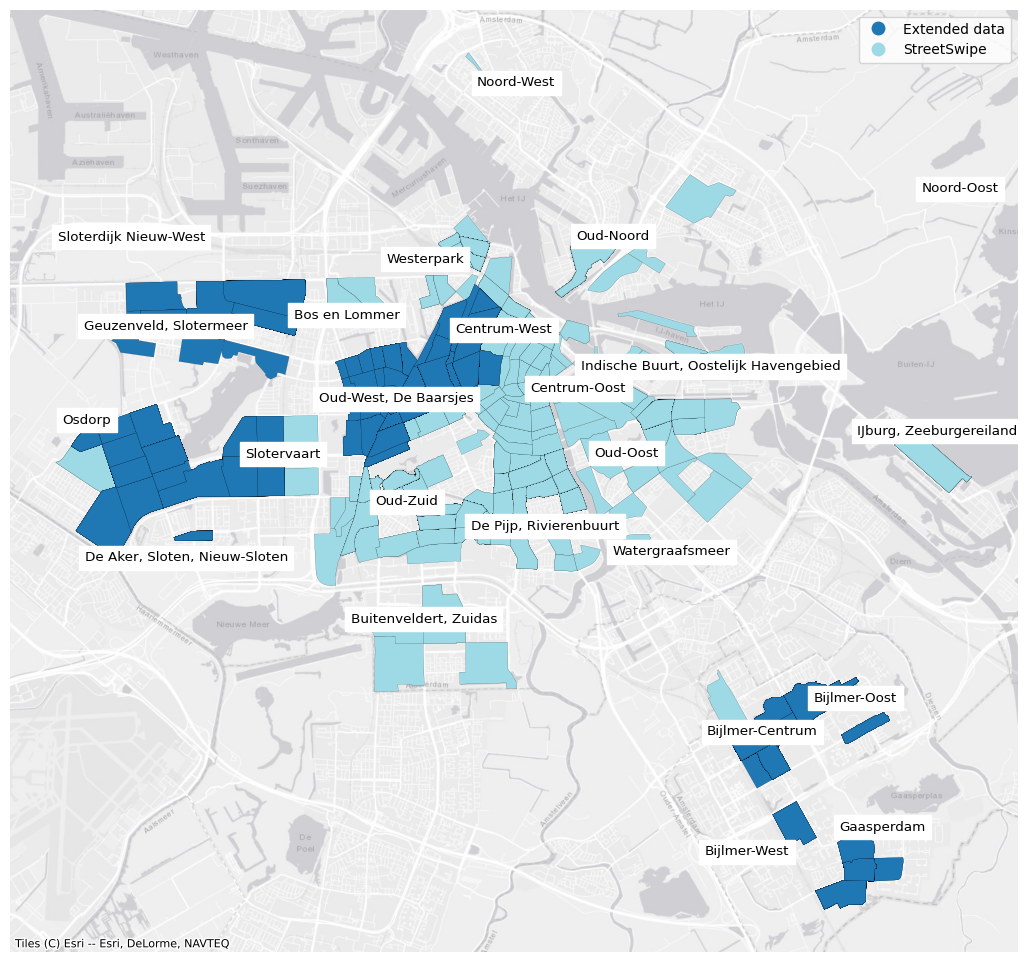

In [228]:
ax = df_all_data_geom.plot(figsize=(13,13), column='dataset', cmap='tab20', legend=True, edgecolor='k', linewidth=0.1, aspect='auto')
# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
# cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
# cx.add_basemap(ax, source=cx.providers.nlmaps.grijs)
cx.add_basemap(ax, source=cx.providers.Esri.WorldGrayCanvas)
# cx.add_basemap(ax,source=cx.providers.OpenStreetMap.HOT)

# cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)

sf2.apply(lambda x: ax.annotate(text=x['Gebied'], xy=x.geometry.centroid.coords[0], ha='center',
                                size=9.7, weight='normal', c='black', backgroundcolor='white'), axis=1);
plt.axis('off')